In [1]:
import numpy as np
import sys
import librosa.display
import matplotlib.pyplot as plt
import audio_processing as ap
import model_eval as me
import heur_eval as ha
import genetic_optimization as GO
import random_shooting as RS
import steepest_descent as SD
import html

# Project Description

In this project we want to get the best possible set of parameters for Random Forest algorithm. This classifier solvse multi classification task and classify trams with respect to the noise they produce.
The main point of this task is to try different heuristics for searching parameters for Random Forest algorithm. 

## Data 

As mentioned before, this project uses sound data from different types of trams. That sound was recorded during acceleration and braking of the trams. More information about types of trams is provided further.

### Training and Testing Data

For this project is used dataset that consists of 2170 records of braiking and accelerating with respect to four different models. 
As a training dataset we use 75% of the data and a testing dataset is represented with 25% of the data. 

## Expected Loss

In order to meausure quality of the output data we have defined specific loss function. 

$$L(\mathbf{x},\mathbf{y},\mathbf{w})=\begin{cases}
1, & \mathbf{y\neq\hat{y}}(\mathbf{x},\mathbf{w})\\
0, & \mathbf{y=\hat{y}}(\mathbf{x},\mathbf{w})
\end{cases},$$

where $\mathbf{x}$ is a vector of the data (sound of a tram), $\mathbf{y}$ is a label, $\mathbf{\hat{y}}$ is predicted label and $\mathbf{w}$ is set of Random Forest parameters. With the usage of the loss function we can write Expected Loss function that is used for qualifying how good or bad our model is. Expected Loss is defined as 

$$\mathbb{E}L(\mathbf{x},\mathbf{y},\mathbf{w})=\frac{1}{N}\sum_{i=1}^{N}L(\mathbf{x}_{i},\mathbf{y}_{i},\mathbf{w}),$$ 
where $\mathbf{x}_{i}$ and $\mathbf{y}_{i}$ is given data from training dataset.


## Experiment Configuration

The experiment is set up the way that we train Random Forest model on 75% percent of the data and then making a prediction on 25% of the data. Quality of the prediction is calculated with the usage of Expected Loss on predicted values. Why do we test model like this? Because it gives sence and we wanted to do like this.

### Parameters 

In this work we decided to tune 5 different parameters of Random Forest model. Those parameters are: 

1. bootstrap
2. cretation 
3. n estimators
4. max depth
5. max features 

We use same random state for all Random Forest models!
More information will be given before models testing.
    
### Heuristics

We decided to test three different heuristics for finding the most optiaml set of parameters. Those heuristics are:
 
1. Random Shooting
2. Genetic Optimization
3. Steepest Descent Approach
    
More information will be given when each model will be initialized    


### Preprocesisng

Define path to the data    

In [2]:
audio_path = "/Users/mark/Documents/Python_Projects/Braiking_Accelerating_classification/tram_demo/dataset/" #PATH TO THE TRAINING DATA. 
acceleration = audio_path+"accelerating/"
braking = audio_path+"braking/"

Import audio data from the path

In [3]:
data_acceleration  = ap.import_data(acceleration)
data_braking  = ap.import_data(acceleration)

Example how the data look like 

In [4]:
new_acc , sr_new_acc = librosa.load(acceleration+"/1_New/tram-2018-11-27-12-44-25_24.87_28.03.mp4.wav")
long_acc , sr_long_acc = librosa.load(acceleration+"/2_CKD_Long/tram-2018-11-17-18-08-33_81.23_85.57.mp4.wav")
short_acc , sr_short_acc = librosa.load(acceleration+"/3_CKD_Short/tram-2018-11-17-20-45-09_129.07_131.57.mp4.wav")
old_acc , sr_old_acc = librosa.load(acceleration+"/4_Old/tram-2018-11-17-14-00-18_255.60_258.87.mp4.wav")
print("")
print("Acceleration of the four different types of trams")


Acceleration of the four different types of trams


![New tram](trams_pics/New.jpg) 
![CKD_Long tram](trams_pics/CKD_long.jpg)
![CKD_short tram](trams_pics/CKD_short.jpg)
![Old tram](trams_pics/Old.jpg)

 
Acceleration of Skoda 15T, CKD_Long, CKD_Short and Old types of trams


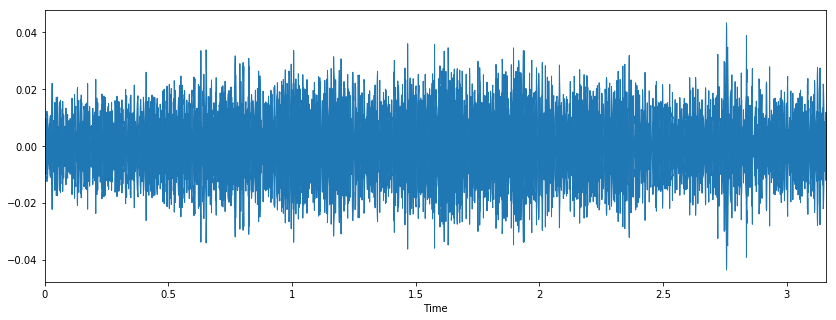

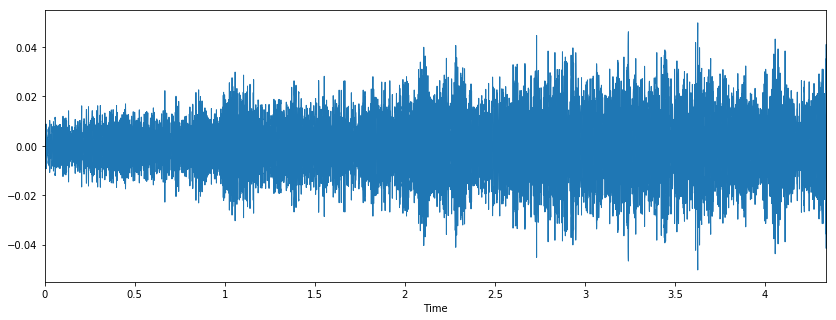

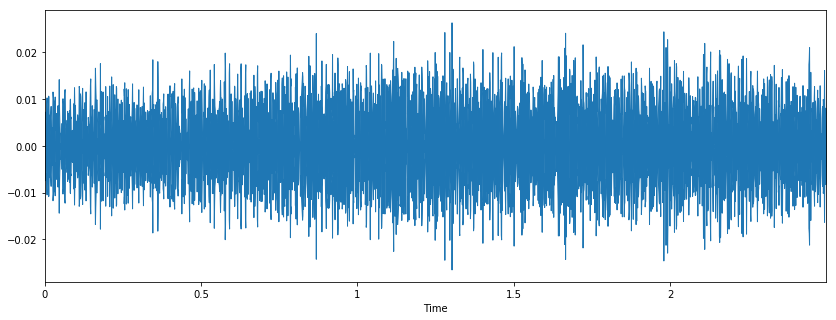

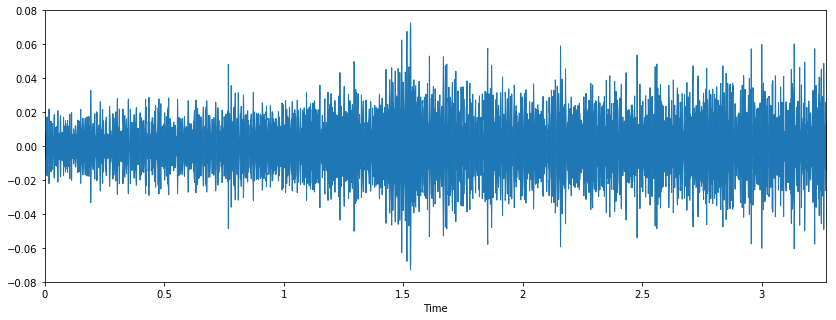

In [5]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(new_acc, sr=sr_new_acc)

plt.figure(figsize=(14, 5))
librosa.display.waveplot(long_acc, sr=sr_long_acc)

plt.figure(figsize=(14, 5))
librosa.display.waveplot(short_acc, sr=sr_short_acc)

plt.figure(figsize=(14, 5))
librosa.display.waveplot(old_acc, sr=sr_old_acc)

print(" ")
print("Acceleration of Skoda 15T, CKD_Long, CKD_Short and Old types of trams")

Creating training datasets from the given data

In [6]:
training_data_acc, training_features_acc, tram_type_features_acc = ap.create_training_dataset(data_acceleration, 1)
training_data_brak, training_features_brak, tram_type_features_brak = ap.create_training_dataset(data_braking, 0)

Concatenate, shuffle the data and prepare for model trainings  

In [7]:
training_data = np.concatenate((training_data_acc, training_data_brak),axis = 0)
training_feature = np.concatenate((training_features_acc, training_features_brak),axis = 0).ravel()
tram_type_features = np.concatenate((tram_type_features_acc, tram_type_features_brak),axis = 0).ravel()
training_data, training_feature, tram_type_features = me.shuffle(training_data, training_feature, tram_type_features, random_state=0)

In this project we will use Random Forest model with same random state for the tram type classification. With the usage of different heuristics we will profide grid search for the Random forest parameters. Parameters grid is defined as follows

```
class randomForestParameters:
    def __init__(self):
        self.bootstrap = [True, False]
        self.criterion = ['gini','entropy']
        self.n_estimators = [value for value in range(10,211)]
        self.max_depth = [value for value in range(2,33)]
        self.max_features = ['auto', 'sqrt', 'log2', None]
```        

Defining empty arrays for output results and number of loops for each heuristics

In [13]:
random_shooting = []

steepest_descent_winsize_1 = []
steepest_descent_winsize_2 = []
steepest_descent_winsize_3 = []

genetic_optimization_5_01 = []
genetic_optimization_5_02 = []
genetic_optimization_5_03 = []

genetic_optimization_10_01 = []
genetic_optimization_10_02 = []
genetic_optimization_10_03 = []

## Random Shooting 

First of all we have used the simlest algorithm. Random shooting algorithm randomly samles data from uniform distribution of parameters.

In [41]:
alg_test_rounds = 10
for test_round in range(alg_test_rounds):
    best_params, loss_function_evolution = RS.random_shooting(training_data, tram_type_features, me.randomForestParameters(), me.loss_function)
    random_shooting.append(loss_function_evolution)
    print(best_params)
    print(" ")

The best loss is 0.321. Accuracy for current model is 0.679
The best loss is 0.133. Accuracy for current model is 0.867
The best loss is 0.133. Accuracy for current model is 0.674
The best loss is 0.094. Accuracy for current model is 0.906
The best loss is 0.091. Accuracy for current model is 0.909
The best loss is 0.091. Accuracy for current model is 0.906
The best loss is 0.091. Accuracy for current model is 0.895
The best loss is 0.091. Accuracy for current model is 0.867
The best loss is 0.091. Accuracy for current model is 0.906
The best loss is 0.091. Accuracy for current model is 0.906
The best loss is 0.091. Accuracy for current model is 0.892
The best loss is 0.087. Accuracy for current model is 0.913
The best loss is 0.087. Accuracy for current model is 0.754
The best loss is 0.087. Accuracy for current model is 0.902
The best loss is 0.087. Accuracy for current model is 0.899
The best loss is 0.087. Accuracy for current model is 0.902
The best loss is 0.087. Accuracy for cur

The best loss is 0.084. Accuracy for current model is 0.892
The best loss is 0.084. Accuracy for current model is 0.909
The best loss is 0.084. Accuracy for current model is 0.799
The best loss is 0.084. Accuracy for current model is 0.632
The best loss is 0.084. Accuracy for current model is 0.62
The best loss is 0.084. Accuracy for current model is 0.862
The best loss is 0.084. Accuracy for current model is 0.894
The best loss is 0.084. Accuracy for current model is 0.895
The best loss is 0.084. Accuracy for current model is 0.906
The best loss is 0.084. Accuracy for current model is 0.913
The best loss is 0.084. Accuracy for current model is 0.867
The best loss is 0.084. Accuracy for current model is 0.909
The best loss is 0.084. Accuracy for current model is 0.902
The best loss is 0.084. Accuracy for current model is 0.909
The best loss is 0.084. Accuracy for current model is 0.881
The best loss is 0.084. Accuracy for current model is 0.902
The best loss is 0.084. Accuracy for curr

The best loss is 0.087. Accuracy for current model is 0.902
The best loss is 0.087. Accuracy for current model is 0.902
The best loss is 0.087. Accuracy for current model is 0.906
The best loss is 0.087. Accuracy for current model is 0.902
The best loss is 0.084. Accuracy for current model is 0.916
The best loss is 0.084. Accuracy for current model is 0.913
The best loss is 0.084. Accuracy for current model is 0.899
The best loss is 0.084. Accuracy for current model is 0.899
The best loss is 0.084. Accuracy for current model is 0.799
The best loss is 0.084. Accuracy for current model is 0.913
The best loss is 0.084. Accuracy for current model is 0.906
The best loss is 0.084. Accuracy for current model is 0.691
The best loss is 0.084. Accuracy for current model is 0.906
The best loss is 0.084. Accuracy for current model is 0.909
The best loss is 0.084. Accuracy for current model is 0.794
The best loss is 0.084. Accuracy for current model is 0.792
The best loss is 0.084. Accuracy for cur

The best loss is 0.101. Accuracy for current model is 0.899
The best loss is 0.091. Accuracy for current model is 0.909
The best loss is 0.091. Accuracy for current model is 0.698
The best loss is 0.091. Accuracy for current model is 0.899
The best loss is 0.091. Accuracy for current model is 0.756
The best loss is 0.091. Accuracy for current model is 0.909
The best loss is 0.091. Accuracy for current model is 0.899
The best loss is 0.091. Accuracy for current model is 0.906
The best loss is 0.091. Accuracy for current model is 0.808
The best loss is 0.091. Accuracy for current model is 0.597
The best loss is 0.091. Accuracy for current model is 0.902
The best loss is 0.091. Accuracy for current model is 0.867
The best loss is 0.091. Accuracy for current model is 0.689
The best loss is 0.091. Accuracy for current model is 0.665
The best loss is 0.091. Accuracy for current model is 0.902
The best loss is 0.091. Accuracy for current model is 0.906
The best loss is 0.091. Accuracy for cur

The best loss is 0.087. Accuracy for current model is 0.609
The best loss is 0.087. Accuracy for current model is 0.81
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.864
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.824
The best loss is 0.087. Accuracy for current model is 0.583
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.897
The best loss is 0.087. Accuracy for current model is 0.607
The best loss is 0.087. Accuracy for current model is 0.906
The best loss is 0.087. Accuracy for current model is 0.646
The best loss is 0.087. Accuracy for current model is 0.906
The best loss is 0.08. Accuracy for current model is 0.92
The best loss is 0.08. Accuracy for current model is 0.845
The best loss is 0.08. Accuracy for current model is 0.913
The best loss is 0.08. Accuracy for current m

The best loss is 0.084. Accuracy for current model is 0.916
The best loss is 0.084. Accuracy for current model is 0.867
The best loss is 0.084. Accuracy for current model is 0.656
The best loss is 0.084. Accuracy for current model is 0.906
The best loss is 0.084. Accuracy for current model is 0.909
The best loss is 0.084. Accuracy for current model is 0.644
The best loss is 0.084. Accuracy for current model is 0.621
The best loss is 0.084. Accuracy for current model is 0.906
The best loss is 0.084. Accuracy for current model is 0.906
The best loss is 0.084. Accuracy for current model is 0.705
The best loss is 0.084. Accuracy for current model is 0.902
The best loss is 0.084. Accuracy for current model is 0.897
The best loss is 0.084. Accuracy for current model is 0.878
The best loss is 0.084. Accuracy for current model is 0.913
The best loss is 0.084. Accuracy for current model is 0.906
The best loss is 0.084. Accuracy for current model is 0.906
The best loss is 0.084. Accuracy for cur

The best loss is 0.084. Accuracy for current model is 0.899
The best loss is 0.084. Accuracy for current model is 0.909
The best loss is 0.084. Accuracy for current model is 0.906
The best loss is 0.084. Accuracy for current model is 0.897
The best loss is 0.084. Accuracy for current model is 0.906
The best loss is 0.084. Accuracy for current model is 0.904
The best loss is 0.084. Accuracy for current model is 0.906
The best loss is 0.084. Accuracy for current model is 0.85
The best loss is 0.084. Accuracy for current model is 0.616
The best loss is 0.084. Accuracy for current model is 0.714
The best loss is 0.084. Accuracy for current model is 0.906
The best loss is 0.084. Accuracy for current model is 0.667
The best loss is 0.084. Accuracy for current model is 0.909
The best loss is 0.084. Accuracy for current model is 0.906
The best loss is 0.084. Accuracy for current model is 0.906
The best loss is 0.084. Accuracy for current model is 0.899
The best loss is 0.084. Accuracy for curr

The best loss is 0.086. Accuracy for current model is 0.906
The best loss is 0.086. Accuracy for current model is 0.902
The best loss is 0.086. Accuracy for current model is 0.866
The best loss is 0.086. Accuracy for current model is 0.66
The best loss is 0.086. Accuracy for current model is 0.712
The best loss is 0.086. Accuracy for current model is 0.616
The best loss is 0.086. Accuracy for current model is 0.806
The best loss is 0.086. Accuracy for current model is 0.906
The best loss is 0.086. Accuracy for current model is 0.899
The best loss is 0.086. Accuracy for current model is 0.892
The best loss is 0.086. Accuracy for current model is 0.909
The best loss is 0.086. Accuracy for current model is 0.743
The best loss is 0.086. Accuracy for current model is 0.906
The best loss is 0.086. Accuracy for current model is 0.902
The best loss is 0.086. Accuracy for current model is 0.913
The best loss is 0.086. Accuracy for current model is 0.888
The best loss is 0.086. Accuracy for curr

|Algorithm      |Mean_Expexted_Loss|Mean_Accuracy|Iterations|
|---------------|------------------|-------------|----------|
|Random_shooting|0.084             |0.915        |100       |

As seen from the results, out function has a lot of local minimums. Thus, it can be expected that Random Shooting can show the best result. However, lets try also different models and then compare them in the end.

## Genetic Optimization


In case of Genetic Optimization, this heuristics has some parameters. Those parameters are mutation and number of population. We will compare six different configurations. Configurations are listed below.

1. Five parents and 10% mutation chance
2. Five parents and 20% mutation chance
3. Five parents and 30% mutation chance

4. Ten parents and 10% mutation chance
5. Ten parents and 20% mutation chance

Because of the computational costs we have reduced amount of testing rounds for Genetic Optimization to 5. Of-course due to this our data have more uncertainty. However, in each round we sample big amount of parents. Thus, we can assume that usage of the 5 testing rounds will not spoil our statistics too much.

### Five parents and 10% mutation chance

In [20]:
alg_test_rounds = 5
for test_round in range(alg_test_rounds):
    best_params, loss_function_evolution = GO.geneteic_optimization(training_data, tram_type_features, me.randomForestParameters(), me.loss_function, 5 , 0.1)
    genetic_optimization_5_01.append(loss_function_evolution)
    print(best_params)
    print(" ")

The best loss is 0.087. Accuracy for current model is 0.913
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.913
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for cur

The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.913
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.913
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for cur

The best loss is 0.091. Accuracy for current model is 0.906
The best loss is 0.091. Accuracy for current model is 0.906
The best loss is 0.091. Accuracy for current model is 0.906
The best loss is 0.091. Accuracy for current model is 0.906
The best loss is 0.091. Accuracy for current model is 0.906
The best loss is 0.091. Accuracy for current model is 0.906
The best loss is 0.091. Accuracy for current model is 0.906
The best loss is 0.091. Accuracy for current model is 0.906
The best loss is 0.091. Accuracy for current model is 0.906
The best loss is 0.091. Accuracy for current model is 0.906
The best loss is 0.091. Accuracy for current model is 0.909
The best loss is 0.091. Accuracy for current model is 0.906
The best loss is 0.091. Accuracy for current model is 0.906
The best loss is 0.091. Accuracy for current model is 0.906
The best loss is 0.091. Accuracy for current model is 0.909
The best loss is 0.091. Accuracy for current model is 0.906
The best loss is 0.091. Accuracy for cur

The best loss is 0.087. Accuracy for current model is 0.913
The best loss is 0.087. Accuracy for current model is 0.906
The best loss is 0.087. Accuracy for current model is 0.906
The best loss is 0.087. Accuracy for current model is 0.906
The best loss is 0.087. Accuracy for current model is 0.906
The best loss is 0.087. Accuracy for current model is 0.906
The best loss is 0.087. Accuracy for current model is 0.906
The best loss is 0.087. Accuracy for current model is 0.906
The best loss is 0.087. Accuracy for current model is 0.906
The best loss is 0.087. Accuracy for current model is 0.906
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.906
The best loss is 0.087. Accuracy for current model is 0.906
The best loss is 0.087. Accuracy for current model is 0.906
The best loss is 0.087. Accuracy for current model is 0.906
The best loss is 0.087. Accuracy for cur

### Five parents and 20% mutation chance

In [19]:
alg_test_rounds = 5
for test_round in range(alg_test_rounds):
    loss_function_evolution = GO.geneteic_optimization(training_data, tram_type_features, me.randomForestParameters(), me.loss_function, 5 , 0.2)
    genetic_optimization_5_02.append(loss_function_evolution)
    print(best_params)
    print(" ")

The best loss is 0.087. Accuracy for current model is 0.913
The best loss is 0.087. Accuracy for current model is 0.906
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.906
The best loss is 0.087. Accuracy for current model is 0.906
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.906
The best loss is 0.087. Accuracy for current model is 0.906
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.906
The best loss is 0.087. Accuracy for current model is 0.906
The best loss is 0.087. Accuracy for current model is 0.906
The best loss is 0.087. Accuracy for current model is 0.906
The best loss is 0.087. Accuracy for current model is 0.906
The best loss is 0.087. Accuracy for current model is 0.906
The best loss is 0.087. Accuracy for cur

The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.913
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.913
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for cur

The best loss is 0.084. Accuracy for current model is 0.902
The best loss is 0.084. Accuracy for current model is 0.909
The best loss is 0.084. Accuracy for current model is 0.902
The best loss is 0.084. Accuracy for current model is 0.902
The best loss is 0.084. Accuracy for current model is 0.906
The best loss is 0.084. Accuracy for current model is 0.904
The best loss is 0.084. Accuracy for current model is 0.906
The best loss is 0.084. Accuracy for current model is 0.902
The best loss is 0.084. Accuracy for current model is 0.902
The best loss is 0.084. Accuracy for current model is 0.902
The best loss is 0.084. Accuracy for current model is 0.902
The best loss is 0.084. Accuracy for current model is 0.902
The best loss is 0.084. Accuracy for current model is 0.902
The best loss is 0.084. Accuracy for current model is 0.904
The best loss is 0.084. Accuracy for current model is 0.902
The best loss is 0.084. Accuracy for current model is 0.909
The best loss is 0.084. Accuracy for cur

The best loss is 0.087. Accuracy for current model is 0.906
The best loss is 0.087. Accuracy for current model is 0.906
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.913
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.084. Accuracy for cur

### Five parents and 30% mutation chance

In [34]:
alg_test_rounds = 5
for test_round in range(alg_test_rounds):
    best_params, loss_function_evolution = GO.geneteic_optimization(training_data, tram_type_features, me.randomForestParameters(), me.loss_function, 5 , 0.3)
    genetic_optimization_5_03.append(loss_function_evolution)
    print(best_params)
    print(" ")

The best loss is 0.094. Accuracy for current model is 0.906
The best loss is 0.094. Accuracy for current model is 0.815
The best loss is 0.094. Accuracy for current model is 0.88
The best loss is 0.094. Accuracy for current model is 0.839
The best loss is 0.094. Accuracy for current model is 0.876
The best loss is 0.094. Accuracy for current model is 0.892
The best loss is 0.094. Accuracy for current model is 0.885
The best loss is 0.094. Accuracy for current model is 0.885
The best loss is 0.094. Accuracy for current model is 0.885
The best loss is 0.094. Accuracy for current model is 0.902
The best loss is 0.094. Accuracy for current model is 0.901
The best loss is 0.094. Accuracy for current model is 0.899
The best loss is 0.094. Accuracy for current model is 0.899
The best loss is 0.091. Accuracy for current model is 0.909
The best loss is 0.091. Accuracy for current model is 0.899
The best loss is 0.091. Accuracy for current model is 0.899
The best loss is 0.091. Accuracy for curr

The best loss is 0.084. Accuracy for current model is 0.906
The best loss is 0.084. Accuracy for current model is 0.913
The best loss is 0.084. Accuracy for current model is 0.906
The best loss is 0.084. Accuracy for current model is 0.909
The best loss is 0.084. Accuracy for current model is 0.906
The best loss is 0.084. Accuracy for current model is 0.906
The best loss is 0.084. Accuracy for current model is 0.906
The best loss is 0.084. Accuracy for current model is 0.906
The best loss is 0.084. Accuracy for current model is 0.906
The best loss is 0.084. Accuracy for current model is 0.906
The best loss is 0.084. Accuracy for current model is 0.906
The best loss is 0.084. Accuracy for current model is 0.906
The best loss is 0.084. Accuracy for current model is 0.909
The best loss is 0.084. Accuracy for current model is 0.909
The best loss is 0.084. Accuracy for current model is 0.909
The best loss is 0.084. Accuracy for current model is 0.909
The best loss is 0.084. Accuracy for cur

The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.911
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for cur

The best loss is 0.087. Accuracy for current model is 0.906
The best loss is 0.087. Accuracy for current model is 0.906
The best loss is 0.087. Accuracy for current model is 0.906
The best loss is 0.087. Accuracy for current model is 0.906
The best loss is 0.087. Accuracy for current model is 0.906
The best loss is 0.087. Accuracy for current model is 0.906
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.906
The best loss is 0.087. Accuracy for current model is 0.906
The best loss is 0.087. Accuracy for current model is 0.906
The best loss is 0.087. Accuracy for current model is 0.906
The best loss is 0.087. Accuracy for current model is 0.906
The best loss is 0.087. Accuracy for current model is 0.906
The best loss is 0.087. Accuracy for current model is 0.906
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.906
The best loss is 0.087. Accuracy for cur

### Ten parents and 10% mutation chance

In [35]:
alg_test_rounds = 5
for test_round in range(alg_test_rounds):
    best_params, loss_function_evolution = GO.geneteic_optimization(training_data, tram_type_features, me.randomForestParameters(), me.loss_function, 10 , 0.1)
    genetic_optimization_10_01.append(loss_function_evolution)
    print(best_params)
    print(" ")

The best loss is 0.084. Accuracy for current model is 0.916
The best loss is 0.084. Accuracy for current model is 0.909
The best loss is 0.084. Accuracy for current model is 0.913
The best loss is 0.084. Accuracy for current model is 0.913
The best loss is 0.084. Accuracy for current model is 0.913
The best loss is 0.084. Accuracy for current model is 0.913
The best loss is 0.084. Accuracy for current model is 0.913
The best loss is 0.084. Accuracy for current model is 0.913
The best loss is 0.084. Accuracy for current model is 0.913
The best loss is 0.084. Accuracy for current model is 0.913
The best loss is 0.084. Accuracy for current model is 0.913
The best loss is 0.084. Accuracy for current model is 0.913
The best loss is 0.084. Accuracy for current model is 0.913
The best loss is 0.084. Accuracy for current model is 0.913
The best loss is 0.084. Accuracy for current model is 0.913
The best loss is 0.084. Accuracy for current model is 0.913
The best loss is 0.084. Accuracy for cur

The best loss is 0.087. Accuracy for current model is 0.913
The best loss is 0.087. Accuracy for current model is 0.913
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.913
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for cur

The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for cur

The best loss is 0.084. Accuracy for current model is 0.911
The best loss is 0.084. Accuracy for current model is 0.913
The best loss is 0.084. Accuracy for current model is 0.913
The best loss is 0.084. Accuracy for current model is 0.911
The best loss is 0.084. Accuracy for current model is 0.911
The best loss is 0.084. Accuracy for current model is 0.911
The best loss is 0.084. Accuracy for current model is 0.911
The best loss is 0.084. Accuracy for current model is 0.911
The best loss is 0.084. Accuracy for current model is 0.911
The best loss is 0.084. Accuracy for current model is 0.911
The best loss is 0.084. Accuracy for current model is 0.911
The best loss is 0.084. Accuracy for current model is 0.911
The best loss is 0.084. Accuracy for current model is 0.911
The best loss is 0.084. Accuracy for current model is 0.911
The best loss is 0.084. Accuracy for current model is 0.911
The best loss is 0.084. Accuracy for current model is 0.911
The best loss is 0.084. Accuracy for cur

### Ten parents and 20% mutation chance

In [36]:
alg_test_rounds = 5
for test_round in range(alg_test_rounds):
    best_params, loss_function_evolution = GO.geneteic_optimization(training_data, tram_type_features, me.randomForestParameters(), me.loss_function, 10 , 0.2)
    genetic_optimization_10_02.append(loss_function_evolution)
    print(best_params)
    print(" ")

The best loss is 0.084. Accuracy for current model is 0.916
The best loss is 0.084. Accuracy for current model is 0.913
The best loss is 0.084. Accuracy for current model is 0.913
The best loss is 0.084. Accuracy for current model is 0.916
The best loss is 0.084. Accuracy for current model is 0.913
The best loss is 0.084. Accuracy for current model is 0.913
The best loss is 0.084. Accuracy for current model is 0.913
The best loss is 0.084. Accuracy for current model is 0.913
The best loss is 0.084. Accuracy for current model is 0.913
The best loss is 0.084. Accuracy for current model is 0.916
The best loss is 0.084. Accuracy for current model is 0.913
The best loss is 0.084. Accuracy for current model is 0.913
The best loss is 0.084. Accuracy for current model is 0.913
The best loss is 0.084. Accuracy for current model is 0.913
The best loss is 0.084. Accuracy for current model is 0.913
The best loss is 0.084. Accuracy for current model is 0.913
The best loss is 0.084. Accuracy for cur

The best loss is 0.084. Accuracy for current model is 0.913
The best loss is 0.084. Accuracy for current model is 0.913
The best loss is 0.084. Accuracy for current model is 0.913
The best loss is 0.084. Accuracy for current model is 0.913
The best loss is 0.084. Accuracy for current model is 0.913
The best loss is 0.084. Accuracy for current model is 0.913
The best loss is 0.084. Accuracy for current model is 0.913
The best loss is 0.084. Accuracy for current model is 0.913
The best loss is 0.084. Accuracy for current model is 0.913
The best loss is 0.084. Accuracy for current model is 0.913
The best loss is 0.084. Accuracy for current model is 0.913
The best loss is 0.084. Accuracy for current model is 0.913
The best loss is 0.084. Accuracy for current model is 0.913
The best loss is 0.084. Accuracy for current model is 0.913
The best loss is 0.084. Accuracy for current model is 0.913
The best loss is 0.084. Accuracy for current model is 0.913
The best loss is 0.084. Accuracy for cur

The best loss is 0.084. Accuracy for current model is 0.909
The best loss is 0.084. Accuracy for current model is 0.909
The best loss is 0.084. Accuracy for current model is 0.909
The best loss is 0.084. Accuracy for current model is 0.909
The best loss is 0.084. Accuracy for current model is 0.909
The best loss is 0.084. Accuracy for current model is 0.909
The best loss is 0.084. Accuracy for current model is 0.909
The best loss is 0.084. Accuracy for current model is 0.909
The best loss is 0.084. Accuracy for current model is 0.909
The best loss is 0.084. Accuracy for current model is 0.909
The best loss is 0.084. Accuracy for current model is 0.909
The best loss is 0.084. Accuracy for current model is 0.909
The best loss is 0.084. Accuracy for current model is 0.909
The best loss is 0.084. Accuracy for current model is 0.909
The best loss is 0.084. Accuracy for current model is 0.909
The best loss is 0.084. Accuracy for current model is 0.909
The best loss is 0.084. Accuracy for cur

The best loss is 0.087. Accuracy for current model is 0.913
The best loss is 0.087. Accuracy for current model is 0.913
The best loss is 0.087. Accuracy for current model is 0.913
The best loss is 0.087. Accuracy for current model is 0.913
The best loss is 0.087. Accuracy for current model is 0.913
The best loss is 0.087. Accuracy for current model is 0.913
The best loss is 0.087. Accuracy for current model is 0.913
The best loss is 0.087. Accuracy for current model is 0.913
The best loss is 0.087. Accuracy for current model is 0.913
The best loss is 0.087. Accuracy for current model is 0.913
The best loss is 0.087. Accuracy for current model is 0.913
The best loss is 0.087. Accuracy for current model is 0.913
The best loss is 0.087. Accuracy for current model is 0.913
The best loss is 0.087. Accuracy for current model is 0.913
The best loss is 0.087. Accuracy for current model is 0.913
The best loss is 0.087. Accuracy for current model is 0.913
The best loss is 0.087. Accuracy for cur

## Genetic Optimization Comparison 
In this part we compare six different models for Genetic Optimization Heuristics. 

[Text(0, 0.5, 'Loss value'),
 Text(0.5, 0, 'Iterations'),
 Text(0.5, 1.0, 'Loss values with respect to genetic optimization, 10 parents and 20% mutation chance')]

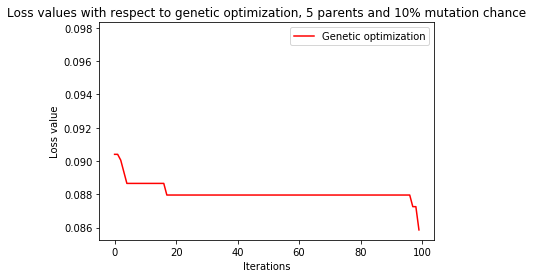

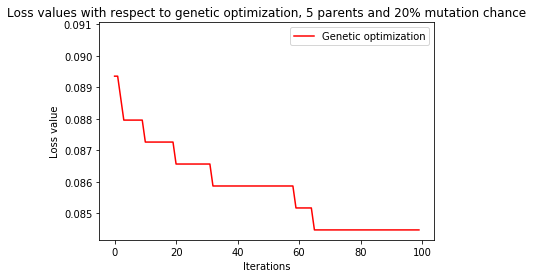

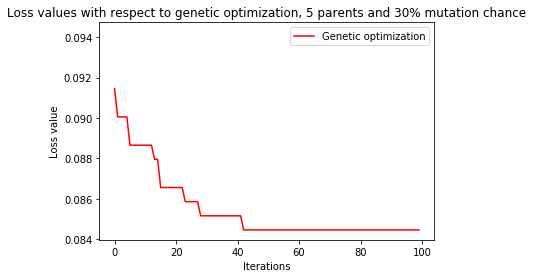

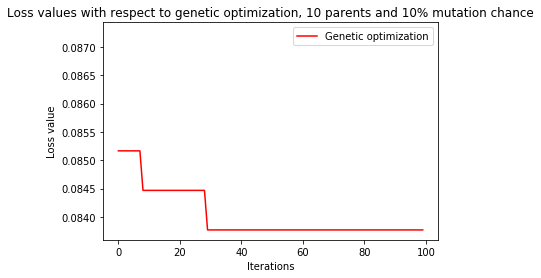

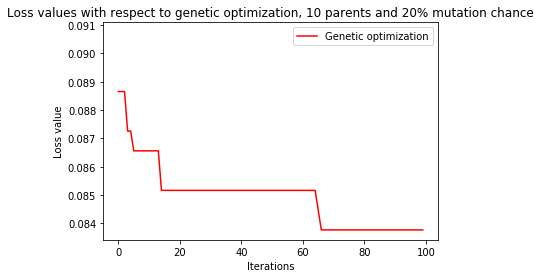

In [37]:
genetic_optimization_5_01_alg_mean, genetic_optimization_5_01_alg_upper, genetic_optimization_5_01_alg_lower = me.calculate_statistics(genetic_optimization_5_01)

genetic_optimization_5_02_alg_mean, genetic_optimization_5_02_alg_upper, genetic_optimization_5_02_alg_lower = me.calculate_statistics(genetic_optimization_5_02)

genetic_optimization_5_03_alg_mean, genetic_optimization_5_03_alg_upper, genetic_optimization_5_03_alg_lower = me.calculate_statistics(genetic_optimization_5_03)

genetic_optimization_10_01_alg_mean, genetic_optimization_10_01_alg_upper, genetic_optimization_10_01_alg_lower = me.calculate_statistics(genetic_optimization_10_01)

genetic_optimization_10_02_alg_mean, genetic_optimization_10_02_alg_upper, genetic_optimization_10_02_alg_lower = me.calculate_statistics(genetic_optimization_10_02)

# genetic_optimization_10_03_alg_mean, genetic_optimization_10_03_alg_upper, genetic_optimization_10_03_alg_lower = me.calculate_statistics(genetic_optimization_10_03)

plt.figure(1)
ax = plt.axes()
ax.plot(genetic_optimization_5_01_alg_mean,"-r", genetic_optimization_5_01_alg_upper, "--r", genetic_optimization_5_01_alg_lower, "--r")
ax.legend(["Genetic optimization"])
ax.set(xlabel="Iterations", ylabel="Loss value",
       title="Loss values with respect to genetic optimization, 5 parents and 10% mutation chance")

plt.figure(2)
ax = plt.axes()
ax.plot(genetic_optimization_5_02_alg_mean,"-r", genetic_optimization_5_02_alg_upper, "--r", genetic_optimization_5_02_alg_lower, "--r")
ax.legend(["Genetic optimization"])
ax.set(xlabel="Iterations", ylabel="Loss value",
       title="Loss values with respect to genetic optimization, 5 parents and 20% mutation chance")

plt.figure(3)
ax = plt.axes()
ax.plot(genetic_optimization_5_03_alg_mean,"-r", genetic_optimization_5_03_alg_upper, "--r", genetic_optimization_5_03_alg_lower, "--r")
ax.legend(["Genetic optimization"])
ax.set(xlabel="Iterations", ylabel="Loss value",
       title="Loss values with respect to genetic optimization, 5 parents and 30% mutation chance")

plt.figure(4)
ax = plt.axes()
ax.plot(genetic_optimization_10_01_alg_mean,"-r", genetic_optimization_10_01_alg_upper, "--r", genetic_optimization_10_01_alg_lower, "--r")
ax.legend(["Genetic optimization"])
ax.set(xlabel="Iterations", ylabel="Loss value",
       title="Loss values with respect to genetic optimization, 10 parents and 10% mutation chance")

plt.figure(5)
ax = plt.axes()
ax.plot(genetic_optimization_10_02_alg_mean,"-r", genetic_optimization_10_02_alg_upper, "--r", genetic_optimization_10_02_alg_lower, "--r")
ax.legend(["Genetic optimization"])
ax.set(xlabel="Iterations", ylabel="Loss value",
       title="Loss values with respect to genetic optimization, 10 parents and 20% mutation chance")

### Loss and Accuracy Values Comparison 

|Algorithm                |Parents|Mean_Expexted_Loss|Mean_Accuracy|Iterations|Mutation_chance|
|-------------------------|-------|------------------|-------------|----------|---------------|
|Genetic_opt_5_par_01_mut |5      |0.086             |0.914        |100       |10%            |
|Genetic_opt_5_par_02_mut |5      |0.084             |0.915        |100       |20%            |
|Genetic_opt_5_par_03_mut |5      |0.084             |0.916        |100       |30%            |
|Genetic_opt_10_par_01_mut|10     |0.083             |0.916        |100       |10%            |
|Genetic_opt_10_par_02_mut|10     |0.083             |0.916        |100       |20%            |

As seen from the table, `mutation` parameter has huge influance. Moreover, it is seen that the more parents you have, the lower loss function you will get. For final comparison we decided to use genetic optimization with `parents = 5` and `mutation = 0.3` chance.
As you could see there is no sence to test the algorithm for `parents = 10` and `mutation = 0.3` because there was better results after switching `parents` to the value of `10`.

## Steepest Descent

Here is represented approach for Steepest Descent heuristics. Due to computational costs it was simplified to the form that is shown here. This heuristics randomly chooses parameters for Random Forest and then randomly generated parameters that are in the neighborhood of the initial parameters. If that parameter has better metrics than heuristics switches generates new set of parameters in a neighborhood of the new set of parameters... Algorithm iterates through 100 iterations. 

In this case we will go through three options when window size is:
1. window size is 1
2. window_size is from 1 to 2
3. window_size is from 1 to 3

### Window size is 1

In [17]:
alg_test_rounds = 12
for test_round in range(alg_test_rounds):
    best_params, loss_function_evolution = SD.steepest_descent(training_data, tram_type_features, me.randomForestParameters(), me.loss_function, 1)
    steepest_descent_winsize_1.append(loss_function_evolution)
    print(best_params)
    print(" ")

The best loss is 0.117. Accuracy for current model is 0.881
The best loss is 0.101. Accuracy for current model is 0.899
The best loss is 0.101. Accuracy for current model is 0.899
The best loss is 0.101. Accuracy for current model is 0.883
The best loss is 0.098. Accuracy for current model is 0.902
The best loss is 0.094. Accuracy for current model is 0.906
The best loss is 0.094. Accuracy for current model is 0.887
The best loss is 0.091. Accuracy for current model is 0.909
The best loss is 0.091. Accuracy for current model is 0.901
The best loss is 0.091. Accuracy for current model is 0.901
The best loss is 0.091. Accuracy for current model is 0.899
The best loss is 0.091. Accuracy for current model is 0.906
The best loss is 0.091. Accuracy for current model is 0.895
The best loss is 0.091. Accuracy for current model is 0.906
The best loss is 0.091. Accuracy for current model is 0.906
The best loss is 0.091. Accuracy for current model is 0.906
The best loss is 0.091. Accuracy for cur

The best loss is 0.089. Accuracy for current model is 0.909
The best loss is 0.089. Accuracy for current model is 0.906
The best loss is 0.089. Accuracy for current model is 0.808
The best loss is 0.089. Accuracy for current model is 0.911
The best loss is 0.089. Accuracy for current model is 0.909
The best loss is 0.089. Accuracy for current model is 0.902
The best loss is 0.089. Accuracy for current model is 0.911
The best loss is 0.089. Accuracy for current model is 0.904
The best loss is 0.089. Accuracy for current model is 0.902
The best loss is 0.089. Accuracy for current model is 0.899
The best loss is 0.089. Accuracy for current model is 0.908
The best loss is 0.089. Accuracy for current model is 0.911
The best loss is 0.089. Accuracy for current model is 0.904
The best loss is 0.089. Accuracy for current model is 0.902
The best loss is 0.089. Accuracy for current model is 0.841
The best loss is 0.089. Accuracy for current model is 0.902
The best loss is 0.089. Accuracy for cur

The best loss is 0.084. Accuracy for current model is 0.906
The best loss is 0.084. Accuracy for current model is 0.906
The best loss is 0.084. Accuracy for current model is 0.906
The best loss is 0.084. Accuracy for current model is 0.902
The best loss is 0.084. Accuracy for current model is 0.906
The best loss is 0.084. Accuracy for current model is 0.902
The best loss is 0.084. Accuracy for current model is 0.906
The best loss is 0.084. Accuracy for current model is 0.916
The best loss is 0.084. Accuracy for current model is 0.906
The best loss is 0.084. Accuracy for current model is 0.906
The best loss is 0.084. Accuracy for current model is 0.916
The best loss is 0.084. Accuracy for current model is 0.906
The best loss is 0.084. Accuracy for current model is 0.902
The best loss is 0.084. Accuracy for current model is 0.906
The best loss is 0.084. Accuracy for current model is 0.906
The best loss is 0.084. Accuracy for current model is 0.906
The best loss is 0.084. Accuracy for cur

The best loss is 0.105. Accuracy for current model is 0.881
The best loss is 0.105. Accuracy for current model is 0.89
The best loss is 0.105. Accuracy for current model is 0.85
The best loss is 0.105. Accuracy for current model is 0.845
The best loss is 0.105. Accuracy for current model is 0.885
The best loss is 0.105. Accuracy for current model is 0.709
The best loss is 0.105. Accuracy for current model is 0.895
The best loss is 0.105. Accuracy for current model is 0.848
The best loss is 0.105. Accuracy for current model is 0.848
The best loss is 0.105. Accuracy for current model is 0.887
The best loss is 0.105. Accuracy for current model is 0.85
The best loss is 0.094. Accuracy for current model is 0.906
The best loss is 0.094. Accuracy for current model is 0.901
The best loss is 0.094. Accuracy for current model is 0.904
The best loss is 0.094. Accuracy for current model is 0.904
The best loss is 0.094. Accuracy for current model is 0.901
The best loss is 0.094. Accuracy for curren

The best loss is 0.094. Accuracy for current model is 0.906
The best loss is 0.094. Accuracy for current model is 0.88
The best loss is 0.094. Accuracy for current model is 0.883
The best loss is 0.094. Accuracy for current model is 0.899
The best loss is 0.094. Accuracy for current model is 0.881
The best loss is 0.094. Accuracy for current model is 0.88
The best loss is 0.094. Accuracy for current model is 0.901
The best loss is 0.094. Accuracy for current model is 0.843
The best loss is 0.094. Accuracy for current model is 0.887
The best loss is 0.094. Accuracy for current model is 0.862
The best loss is 0.094. Accuracy for current model is 0.885
The best loss is 0.094. Accuracy for current model is 0.899
The best loss is 0.094. Accuracy for current model is 0.897
The best loss is 0.094. Accuracy for current model is 0.895
The best loss is 0.094. Accuracy for current model is 0.904
The best loss is 0.094. Accuracy for current model is 0.878
The best loss is 0.094. Accuracy for curre

The best loss is 0.091. Accuracy for current model is 0.899
The best loss is 0.091. Accuracy for current model is 0.908
The best loss is 0.091. Accuracy for current model is 0.906
The best loss is 0.091. Accuracy for current model is 0.897
The best loss is 0.091. Accuracy for current model is 0.89
The best loss is 0.091. Accuracy for current model is 0.901
The best loss is 0.091. Accuracy for current model is 0.869
The best loss is 0.091. Accuracy for current model is 0.908
The best loss is 0.091. Accuracy for current model is 0.82
The best loss is 0.091. Accuracy for current model is 0.887
The best loss is 0.091. Accuracy for current model is 0.902
The best loss is 0.091. Accuracy for current model is 0.885
The best loss is 0.091. Accuracy for current model is 0.897
The best loss is 0.091. Accuracy for current model is 0.897
The best loss is 0.091. Accuracy for current model is 0.909
The best loss is 0.091. Accuracy for current model is 0.899
The best loss is 0.091. Accuracy for curre

The best loss is 0.091. Accuracy for current model is 0.867
The best loss is 0.091. Accuracy for current model is 0.902
The best loss is 0.091. Accuracy for current model is 0.892
The best loss is 0.091. Accuracy for current model is 0.902
The best loss is 0.091. Accuracy for current model is 0.902
The best loss is 0.091. Accuracy for current model is 0.895
The best loss is 0.091. Accuracy for current model is 0.906
The best loss is 0.091. Accuracy for current model is 0.902
The best loss is 0.091. Accuracy for current model is 0.906
The best loss is 0.091. Accuracy for current model is 0.909
The best loss is 0.091. Accuracy for current model is 0.902
The best loss is 0.091. Accuracy for current model is 0.902
The best loss is 0.091. Accuracy for current model is 0.909
The best loss is 0.091. Accuracy for current model is 0.902
The best loss is 0.091. Accuracy for current model is 0.906
The best loss is 0.091. Accuracy for current model is 0.902
The best loss is 0.091. Accuracy for cur

The best loss is 0.08. Accuracy for current model is 0.911
The best loss is 0.08. Accuracy for current model is 0.895
The best loss is 0.08. Accuracy for current model is 0.906
The best loss is 0.08. Accuracy for current model is 0.902
The best loss is 0.08. Accuracy for current model is 0.892
The best loss is 0.08. Accuracy for current model is 0.902
The best loss is 0.08. Accuracy for current model is 0.909
The best loss is 0.08. Accuracy for current model is 0.892
The best loss is 0.08. Accuracy for current model is 0.892
The best loss is 0.08. Accuracy for current model is 0.909
The best loss is 0.08. Accuracy for current model is 0.906
The best loss is 0.08. Accuracy for current model is 0.906
The best loss is 0.08. Accuracy for current model is 0.867
The best loss is 0.08. Accuracy for current model is 0.911
The best loss is 0.08. Accuracy for current model is 0.906
The best loss is 0.08. Accuracy for current model is 0.906
The best loss is 0.08. Accuracy for current model is 0.8

The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.913
The best loss is 0.087. Accuracy for current model is 0.895
The best loss is 0.087. Accuracy for current model is 0.913
The best loss is 0.087. Accuracy for current model is 0.894
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.913
The best loss is 0.087. Accuracy for current model is 0.902
The best loss is 0.087. Accuracy for current model is 0.857
The best loss is 0.087. Accuracy for current model is 0.913
The best loss is 0.087. Accuracy for current model is 0.911
The best loss is 0.087. Accuracy for current model is 0.857
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.911
The best loss is 0.087. Accuracy for current model is 0.913
The best loss is 0.087. Accuracy for current model is 0.894
The best loss is 0.087. Accuracy for cur

### window_size is from 1 to 2

In [9]:
alg_test_rounds = 12
for test_round in range(alg_test_rounds):
    best_params, loss_function_evolution = SD.steepest_descent(training_data, tram_type_features, me.randomForestParameters(), me.loss_function, 2)
    steepest_descent_winsize_2.append(loss_function_evolution)
    print(best_params)
    print(" ")

The best loss is 0.101. Accuracy for current model is 0.899
The best loss is 0.101. Accuracy for current model is 0.794
The best loss is 0.101. Accuracy for current model is 0.876
The best loss is 0.098. Accuracy for current model is 0.902
The best loss is 0.084. Accuracy for current model is 0.916
The best loss is 0.084. Accuracy for current model is 0.909
The best loss is 0.084. Accuracy for current model is 0.902
The best loss is 0.084. Accuracy for current model is 0.789
The best loss is 0.084. Accuracy for current model is 0.899
The best loss is 0.084. Accuracy for current model is 0.871
The best loss is 0.084. Accuracy for current model is 0.904
The best loss is 0.084. Accuracy for current model is 0.916
The best loss is 0.084. Accuracy for current model is 0.895
The best loss is 0.084. Accuracy for current model is 0.909
The best loss is 0.084. Accuracy for current model is 0.902
The best loss is 0.084. Accuracy for current model is 0.897
The best loss is 0.084. Accuracy for cur

The best loss is 0.086. Accuracy for current model is 0.902
The best loss is 0.086. Accuracy for current model is 0.909
The best loss is 0.086. Accuracy for current model is 0.902
The best loss is 0.086. Accuracy for current model is 0.909
The best loss is 0.086. Accuracy for current model is 0.904
The best loss is 0.086. Accuracy for current model is 0.909
The best loss is 0.086. Accuracy for current model is 0.906
The best loss is 0.086. Accuracy for current model is 0.909
The best loss is 0.086. Accuracy for current model is 0.906
The best loss is 0.086. Accuracy for current model is 0.899
The best loss is 0.086. Accuracy for current model is 0.909
The best loss is 0.086. Accuracy for current model is 0.906
The best loss is 0.086. Accuracy for current model is 0.906
The best loss is 0.086. Accuracy for current model is 0.904
The best loss is 0.086. Accuracy for current model is 0.909
The best loss is 0.086. Accuracy for current model is 0.908
The best loss is 0.086. Accuracy for cur

The best loss is 0.084. Accuracy for current model is 0.916
The best loss is 0.084. Accuracy for current model is 0.899
The best loss is 0.084. Accuracy for current model is 0.902
The best loss is 0.084. Accuracy for current model is 0.906
The best loss is 0.084. Accuracy for current model is 0.906
The best loss is 0.084. Accuracy for current model is 0.902
The best loss is 0.084. Accuracy for current model is 0.899
The best loss is 0.084. Accuracy for current model is 0.906
The best loss is 0.084. Accuracy for current model is 0.906
The best loss is 0.084. Accuracy for current model is 0.916
The best loss is 0.084. Accuracy for current model is 0.906
The best loss is 0.084. Accuracy for current model is 0.909
The best loss is 0.084. Accuracy for current model is 0.906
The best loss is 0.084. Accuracy for current model is 0.909
The best loss is 0.084. Accuracy for current model is 0.899
The best loss is 0.084. Accuracy for current model is 0.909
The best loss is 0.084. Accuracy for cur

The best loss is 0.091. Accuracy for current model is 0.906
The best loss is 0.091. Accuracy for current model is 0.902
The best loss is 0.091. Accuracy for current model is 0.899
The best loss is 0.091. Accuracy for current model is 0.906
The best loss is 0.087. Accuracy for current model is 0.913
The best loss is 0.08. Accuracy for current model is 0.92
The best loss is 0.08. Accuracy for current model is 0.902
The best loss is 0.08. Accuracy for current model is 0.895
The best loss is 0.08. Accuracy for current model is 0.909
The best loss is 0.08. Accuracy for current model is 0.906
The best loss is 0.08. Accuracy for current model is 0.906
The best loss is 0.08. Accuracy for current model is 0.913
The best loss is 0.08. Accuracy for current model is 0.906
The best loss is 0.08. Accuracy for current model is 0.909
The best loss is 0.08. Accuracy for current model is 0.913
The best loss is 0.08. Accuracy for current model is 0.909
The best loss is 0.08. Accuracy for current model is

The best loss is 0.087. Accuracy for current model is 0.906
The best loss is 0.087. Accuracy for current model is 0.913
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.902
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.867
The best loss is 0.087. Accuracy for current model is 0.906
The best loss is 0.087. Accuracy for current model is 0.902
The best loss is 0.087. Accuracy for current model is 0.902
The best loss is 0.087. Accuracy for current model is 0.906
The best loss is 0.087. Accuracy for current model is 0.906
The best loss is 0.087. Accuracy for current model is 0.906
The best loss is 0.087. Accuracy for current model is 0.913
The best loss is 0.087. Accuracy for current model is 0.906
The best loss is 0.087. Accuracy for current model is 0.913
The best loss is 0.087. Accuracy for current model is 0.913
The best loss is 0.087. Accuracy for cur

The best loss is 0.087. Accuracy for current model is 0.899
The best loss is 0.087. Accuracy for current model is 0.906
The best loss is 0.087. Accuracy for current model is 0.913
The best loss is 0.087. Accuracy for current model is 0.899
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.902
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.913
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.913
The best loss is 0.087. Accuracy for current model is 0.913
The best loss is 0.087. Accuracy for current model is 0.906
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.899
The best loss is 0.087. Accuracy for current model is 0.906
The best loss is 0.087. Accuracy for current model is 0.913
The best loss is 0.087. Accuracy for cur

The best loss is 0.293. Accuracy for current model is 0.682
The best loss is 0.293. Accuracy for current model is 0.679
The best loss is 0.253. Accuracy for current model is 0.747
The best loss is 0.182. Accuracy for current model is 0.818
The best loss is 0.182. Accuracy for current model is 0.778
The best loss is 0.182. Accuracy for current model is 0.775
The best loss is 0.161. Accuracy for current model is 0.839
The best loss is 0.127. Accuracy for current model is 0.873
The best loss is 0.11. Accuracy for current model is 0.89
The best loss is 0.11. Accuracy for current model is 0.867
The best loss is 0.11. Accuracy for current model is 0.885
The best loss is 0.11. Accuracy for current model is 0.866
The best loss is 0.11. Accuracy for current model is 0.798
The best loss is 0.11. Accuracy for current model is 0.883
The best loss is 0.105. Accuracy for current model is 0.895
The best loss is 0.098. Accuracy for current model is 0.902
The best loss is 0.098. Accuracy for current mo

The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.867
The best loss is 0.087. Accuracy for current model is 0.899
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.906
The best loss is 0.087. Accuracy for current model is 0.867
The best loss is 0.087. Accuracy for current model is 0.906
The best loss is 0.087. Accuracy for current model is 0.913
The best loss is 0.087. Accuracy for current model is 0.913
The best loss is 0.087. Accuracy for current model is 0.906
The best loss is 0.087. Accuracy for current model is 0.906
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.902
The best loss is 0.087. Accuracy for current model is 0.899
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.902
The best loss is 0.087. Accuracy for cur

The best loss is 0.087. Accuracy for current model is 0.913
The best loss is 0.087. Accuracy for current model is 0.867
The best loss is 0.087. Accuracy for current model is 0.906
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.895
The best loss is 0.087. Accuracy for current model is 0.902
The best loss is 0.087. Accuracy for current model is 0.913
The best loss is 0.087. Accuracy for current model is 0.902
The best loss is 0.087. Accuracy for current model is 0.902
The best loss is 0.087. Accuracy for current model is 0.902
The best loss is 0.087. Accuracy for current model is 0.906
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.892
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for cur

### window_size is from 1 to 3

In [14]:
alg_test_rounds = 12
for test_round in range(alg_test_rounds):
    best_params, loss_function_evolution = SD.steepest_descent(training_data, tram_type_features, me.randomForestParameters(), me.loss_function, 3)
    steepest_descent_winsize_3.append(loss_function_evolution)
    print(best_params)
    print(" ")

The best loss is 0.091. Accuracy for current model is 0.909
The best loss is 0.091. Accuracy for current model is 0.909
The best loss is 0.084. Accuracy for current model is 0.916
The best loss is 0.084. Accuracy for current model is 0.897
The best loss is 0.084. Accuracy for current model is 0.895
The best loss is 0.084. Accuracy for current model is 0.895
The best loss is 0.084. Accuracy for current model is 0.894
The best loss is 0.084. Accuracy for current model is 0.906
The best loss is 0.084. Accuracy for current model is 0.895
The best loss is 0.084. Accuracy for current model is 0.901
The best loss is 0.084. Accuracy for current model is 0.916
The best loss is 0.084. Accuracy for current model is 0.888
The best loss is 0.084. Accuracy for current model is 0.892
The best loss is 0.084. Accuracy for current model is 0.916
The best loss is 0.084. Accuracy for current model is 0.902
The best loss is 0.084. Accuracy for current model is 0.895
The best loss is 0.084. Accuracy for cur

The best loss is 0.084. Accuracy for current model is 0.909
The best loss is 0.084. Accuracy for current model is 0.909
The best loss is 0.084. Accuracy for current model is 0.906
The best loss is 0.084. Accuracy for current model is 0.906
The best loss is 0.084. Accuracy for current model is 0.909
The best loss is 0.084. Accuracy for current model is 0.906
The best loss is 0.084. Accuracy for current model is 0.916
The best loss is 0.084. Accuracy for current model is 0.895
The best loss is 0.084. Accuracy for current model is 0.908
The best loss is 0.084. Accuracy for current model is 0.906
The best loss is 0.084. Accuracy for current model is 0.906
The best loss is 0.084. Accuracy for current model is 0.906
The best loss is 0.084. Accuracy for current model is 0.906
The best loss is 0.084. Accuracy for current model is 0.916
The best loss is 0.084. Accuracy for current model is 0.895
The best loss is 0.084. Accuracy for current model is 0.906
The best loss is 0.084. Accuracy for cur

The best loss is 0.087. Accuracy for current model is 0.906
The best loss is 0.087. Accuracy for current model is 0.906
The best loss is 0.087. Accuracy for current model is 0.902
The best loss is 0.087. Accuracy for current model is 0.906
The best loss is 0.087. Accuracy for current model is 0.913
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.895
The best loss is 0.087. Accuracy for current model is 0.913
The best loss is 0.087. Accuracy for current model is 0.906
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.899
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.906
The best loss is 0.087. Accuracy for current model is 0.902
The best loss is 0.087. Accuracy for current model is 0.902
The best loss is 0.087. Accuracy for current model is 0.906
The best loss is 0.087. Accuracy for cur

The best loss is 0.091. Accuracy for current model is 0.909
The best loss is 0.091. Accuracy for current model is 0.895
The best loss is 0.091. Accuracy for current model is 0.906
The best loss is 0.091. Accuracy for current model is 0.909
The best loss is 0.091. Accuracy for current model is 0.909
The best loss is 0.091. Accuracy for current model is 0.906
The best loss is 0.091. Accuracy for current model is 0.895
The best loss is 0.091. Accuracy for current model is 0.902
The best loss is 0.091. Accuracy for current model is 0.895
The best loss is 0.091. Accuracy for current model is 0.909
The best loss is 0.091. Accuracy for current model is 0.902
The best loss is 0.091. Accuracy for current model is 0.906
The best loss is 0.091. Accuracy for current model is 0.902
The best loss is 0.091. Accuracy for current model is 0.902
The best loss is 0.091. Accuracy for current model is 0.895
The best loss is 0.091. Accuracy for current model is 0.906
The best loss is 0.091. Accuracy for cur

The best loss is 0.092. Accuracy for current model is 0.887
The best loss is 0.092. Accuracy for current model is 0.892
The best loss is 0.092. Accuracy for current model is 0.904
The best loss is 0.092. Accuracy for current model is 0.902
The best loss is 0.092. Accuracy for current model is 0.892
The best loss is 0.092. Accuracy for current model is 0.885
The best loss is 0.092. Accuracy for current model is 0.899
The best loss is 0.092. Accuracy for current model is 0.902
The best loss is 0.092. Accuracy for current model is 0.888
The best loss is 0.092. Accuracy for current model is 0.908
The best loss is 0.092. Accuracy for current model is 0.881
The best loss is 0.092. Accuracy for current model is 0.895
The best loss is 0.092. Accuracy for current model is 0.871
The best loss is 0.092. Accuracy for current model is 0.904
The best loss is 0.092. Accuracy for current model is 0.892
The best loss is 0.092. Accuracy for current model is 0.885
The best loss is 0.092. Accuracy for cur

The best loss is 0.084. Accuracy for current model is 0.909
The best loss is 0.084. Accuracy for current model is 0.829
The best loss is 0.084. Accuracy for current model is 0.909
The best loss is 0.084. Accuracy for current model is 0.909
The best loss is 0.084. Accuracy for current model is 0.906
The best loss is 0.084. Accuracy for current model is 0.909
The best loss is 0.084. Accuracy for current model is 0.902
The best loss is 0.084. Accuracy for current model is 0.892
The best loss is 0.084. Accuracy for current model is 0.913
The best loss is 0.084. Accuracy for current model is 0.913
The best loss is 0.084. Accuracy for current model is 0.857
The best loss is 0.084. Accuracy for current model is 0.895
The best loss is 0.084. Accuracy for current model is 0.904
The best loss is 0.084. Accuracy for current model is 0.906
The best loss is 0.084. Accuracy for current model is 0.909
The best loss is 0.084. Accuracy for current model is 0.906
The best loss is 0.084. Accuracy for cur

The best loss is 0.229. Accuracy for current model is 0.67
The best loss is 0.229. Accuracy for current model is 0.712
The best loss is 0.168. Accuracy for current model is 0.832
The best loss is 0.147. Accuracy for current model is 0.853
The best loss is 0.115. Accuracy for current model is 0.885
The best loss is 0.101. Accuracy for current model is 0.899
The best loss is 0.091. Accuracy for current model is 0.909
The best loss is 0.091. Accuracy for current model is 0.899
The best loss is 0.091. Accuracy for current model is 0.906
The best loss is 0.091. Accuracy for current model is 0.906
The best loss is 0.091. Accuracy for current model is 0.906
The best loss is 0.091. Accuracy for current model is 0.895
The best loss is 0.091. Accuracy for current model is 0.909
The best loss is 0.091. Accuracy for current model is 0.906
The best loss is 0.091. Accuracy for current model is 0.899
The best loss is 0.091. Accuracy for current model is 0.902
The best loss is 0.091. Accuracy for curr

The best loss is 0.086. Accuracy for current model is 0.906
The best loss is 0.086. Accuracy for current model is 0.913
The best loss is 0.086. Accuracy for current model is 0.873
The best loss is 0.086. Accuracy for current model is 0.909
The best loss is 0.086. Accuracy for current model is 0.906
The best loss is 0.086. Accuracy for current model is 0.906
The best loss is 0.086. Accuracy for current model is 0.901
The best loss is 0.086. Accuracy for current model is 0.906
The best loss is 0.086. Accuracy for current model is 0.894
The best loss is 0.086. Accuracy for current model is 0.899
The best loss is 0.086. Accuracy for current model is 0.906
The best loss is 0.086. Accuracy for current model is 0.914
The best loss is 0.086. Accuracy for current model is 0.906
The best loss is 0.086. Accuracy for current model is 0.906
The best loss is 0.086. Accuracy for current model is 0.841
The best loss is 0.086. Accuracy for current model is 0.888
The best loss is 0.086. Accuracy for cur

The best loss is 0.087. Accuracy for current model is 0.895
The best loss is 0.087. Accuracy for current model is 0.906
The best loss is 0.087. Accuracy for current model is 0.892
The best loss is 0.087. Accuracy for current model is 0.899
The best loss is 0.087. Accuracy for current model is 0.867
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.899
The best loss is 0.087. Accuracy for current model is 0.901
The best loss is 0.087. Accuracy for current model is 0.902
The best loss is 0.087. Accuracy for current model is 0.902
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.89
The best loss is 0.087. Accuracy for current model is 0.899
The best loss is 0.087. Accuracy for current model is 0.909
The best loss is 0.087. Accuracy for current model is 0.902
The best loss is 0.087. Accuracy for current model is 0.913
The best loss is 0.087. Accuracy for curr

## Steepest Descent Comparison 
In this part we compare three different models for Steepest Descent Heuristics. 

[Text(0, 0.5, 'Loss value'),
 Text(0.5, 0, 'Iterations'),
 Text(0.5, 1.0, 'Loss values with respect to steepest descent')]

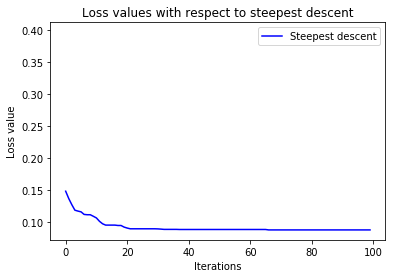

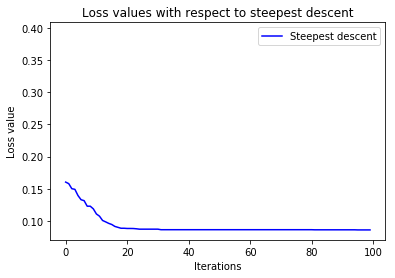

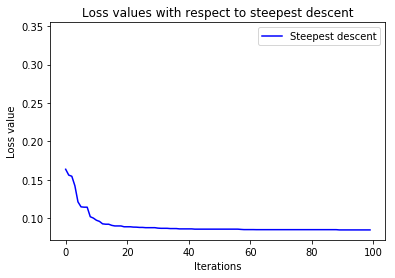

In [18]:
step_desc_winsize_1_alg_mean, step_desc_winsize_1_alg_upper, step_desc_winsize_1_alg_lower = me.calculate_statistics(steepest_descent_winsize_1)

step_desc_winsize_2_alg_mean, step_desc_winsize_2_alg_upper, step_desc_winsize_2_alg_lower = me.calculate_statistics(steepest_descent_winsize_2)

step_desc_winsize_3_alg_mean, step_desc_winsize_3_alg_upper, step_desc_winsize_3_alg_lower = me.calculate_statistics(steepest_descent_winsize_3)

plt.figure(1)
ax = plt.axes()
ax.plot(step_desc_winsize_1_alg_mean,"-b",step_desc_winsize_1_alg_upper, "--b",step_desc_winsize_1_alg_lower, "--b")
ax.legend(["Steepest descent"])
ax.set(xlabel="Iterations", ylabel="Loss value",
       title="Loss values with respect to steepest descent and window size 1")

plt.figure(2)
ax = plt.axes()
ax.plot(step_desc_winsize_2_alg_mean,"-b",step_desc_winsize_2_alg_upper, "--b",step_desc_winsize_2_alg_lower, "--b")
ax.legend(["Steepest descent"])
ax.set(xlabel="Iterations", ylabel="Loss value",
       title="Loss values with respect to steepest descent and window size 2")

plt.figure(3)
ax = plt.axes()
ax.plot(step_desc_winsize_3_alg_mean,"-b",step_desc_winsize_3_alg_upper, "--b",step_desc_winsize_3_alg_lower, "--b")
ax.legend(["Steepest descent"])
ax.set(xlabel="Iterations", ylabel="Loss value",
       title="Loss values with respect to steepest descent and window size 3")

### Loss and Accuracy Values Comparison 

|Algorithm     |Window_size|Mean_Expexted_Loss|Mean_Accuracy|Iterations|
|--------------|-----------|------------------|-------------|----------|
|Steepest_dec_1|1          |0.088             |0.912        |100       |
|Steepers_dec_2|2          |0.086             |0.914        |100       |
|Steepers_dec_3|3          |0.085             |0.915        |100       |

As a result, basing on the fraphs and a table with values we can conclude that the most efficient algorithm was the one with `window_size` parameter that equals to 3. It has both the lowest expected loss and accuracy. Moreover, it is seen that algorithm with `window_size = 3` converges faster than two other steepest descent heuristics. Thus, steepest descent with `windows_size = 3` will be used for further comparisons.  

# Comparison of Different Heuristcs with Tuned Parameters

In this part we choose the best heuristics for Random Forest parameters serach. We compare 

1. Random Shooting
2. Genetic Optimization with `5` parents ans `30%` mutation chance
3. Steepest Descent with `window_size = 3`

Comparison results are both shown on graphs and in a table below.

[Text(0, 0.5, 'Loss value'),
 Text(0.5, 0, 'Iterations'),
 Text(0.5, 1.0, 'Loss values with respect to genetic optimization')]

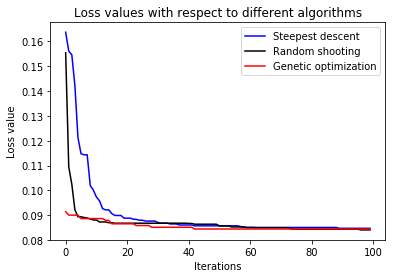

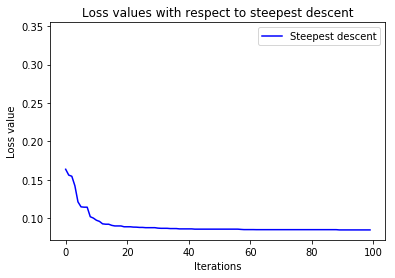

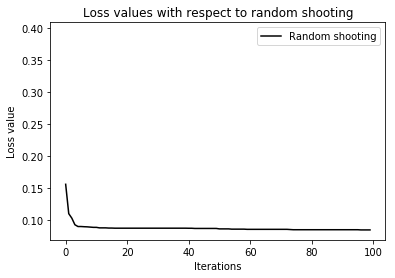

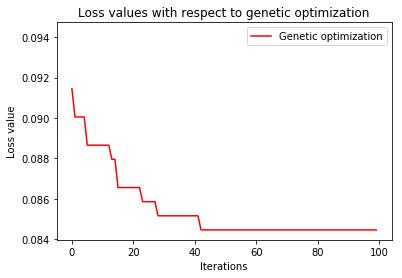

In [45]:
random_shooting_mean, random_shooting_upper, random_shooting_lower = me.calculate_statistics(random_shooting)

#Plotting
plt.figure(1)
ax = plt.axes()
ax.plot(step_desc_winsize_3_alg_mean,"-b", random_shooting_mean, "-k", genetic_optimization_5_03_alg_mean,"-r")
ax.legend(["Steepest descent","Random shooting","Genetic optimization"])
ax.set(xlabel="Iterations", ylabel="Loss value",
       title="Loss values with respect to different algorithms")

plt.figure(2)
ax = plt.axes()
ax.plot(step_desc_winsize_3_alg_mean,"-b",step_desc_winsize_3_alg_upper, "--b",step_desc_winsize_3_alg_lower, "--b")
ax.legend(["Steepest descent"])
ax.set(xlabel="Iterations", ylabel="Loss value",
       title="Loss values with respect to steepest descent")

plt.figure(3)
ax = plt.axes()
ax.plot(random_shooting_mean, "-k", random_shooting_upper, "--k",random_shooting_lower, "--k")
ax.legend(["Random shooting"])
ax.set(xlabel="Iterations", ylabel="Loss value",
       title="Loss values with respect to random shooting")

plt.figure(4)
ax = plt.axes()
ax.plot(genetic_optimization_5_03_alg_mean,"-r", genetic_optimization_5_03_alg_upper, "--r", genetic_optimization_5_03_alg_lower, "--r")
ax.legend(["Genetic optimization"])
ax.set(xlabel="Iterations", ylabel="Loss value",
       title="Loss values with respect to genetic optimization")



As a result, basing on the metrics and graphs, the best heuristic that solves frid search for Random Forest is Genetic Optimization with `5` `parents` and `30%` `mutation` chance. 